In [114]:
import sys
import copy
sys.path.insert(0, "..")
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection_plotter import Animator, Atom_Collection_Plotter
from classes.descriptors import CoulombMatrixSpectrum
from classes.pca import PCA
from classes.kmeans import KMeans
import matplotlib.pyplot as plt
import numpy as np
plt.rc('animation', html='jshtml')

In [115]:
pos_flat = np.loadtxt('lj10clusters.txt')
positions = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)
atom_cols = [Atom_Collection([Atom(position=pos) for pos in poses]) for poses in positions][0:35]
coul_desc = CoulombMatrixSpectrum()
fit_data = [coul_desc.get_descriptor(atom_col=atom_col) for atom_col in atom_cols]

descriptors = []
rattled_cols = []
for atom_col in atom_cols:
    for i in range(30):
        atom_col_copy = copy.deepcopy(atom_col)
        atom_col_copy.rattle_atoms(delta=0.05, rattle_steps=np.random.randint(0, 4))
        descriptor = coul_desc.get_descriptor(atom_col=atom_col_copy)
        descriptors.append(descriptor)
        rattled_cols.append(atom_col_copy)

descriptors = [coul_desc.get_descriptor(atom_col=atom_col) for atom_col in rattled_cols]

pca = PCA(2)
pca.fit(data=fit_data)

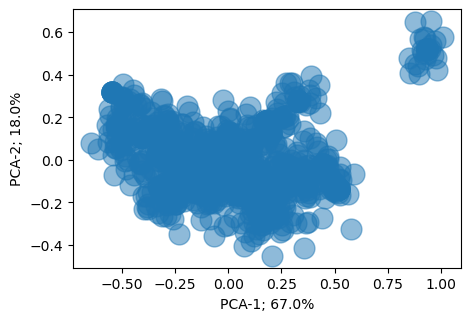

In [116]:
fig, ax = plt.subplots(figsize=(5,5))
trans_data = pca.transform(data=descriptors)
ax.plot(trans_data[:,0], trans_data[:,1], 'o', markersize=15, alpha=0.5)
ax.set_xlabel(f"PCA-1; {round(pca.explained_var[0], 2)*100}%")
ax.set_ylabel(f"PCA-2; {round(pca.explained_var[1], 2)*100}%")
ax.set_aspect("equal")

In [117]:
kmeans = KMeans(n_clusters=8, max_iter=100)
kmeans.fit(data=np.array(descriptors), init_mus=np.array([descriptors[i] for i in np.random.randint(0, len(descriptors), size=8)]))

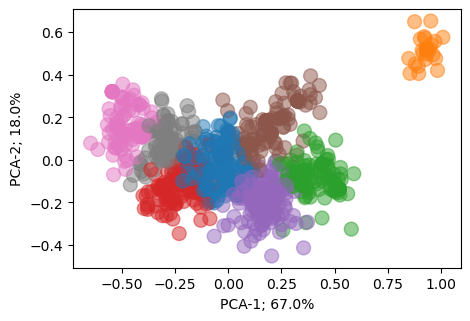

In [118]:
fig, ax = plt.subplots(figsize=(5,5))
labels = kmeans.predict(descriptors)
ax.scatter(trans_data[:,0],trans_data[:,1],c=[f"C{label}" for label in labels], s=100, alpha=0.5)
trans_mus = pca.transform(data=kmeans.mus)
ax.set_xlabel(f"PCA-1; {round(pca.explained_var[0], 2)*100}%")
ax.set_ylabel(f"PCA-2; {round(pca.explained_var[1], 2)*100}%")
ax.set_aspect("equal")

In [126]:
label_types = np.linspace(0, 7, 8, dtype=int)
filled = np.zeros(shape=label_types.shape, dtype=bool)
atom_cols_labelled = {}
indices_labelled = {}

for label_type in label_types:
    atom_cols_labelled[label_type] = []
    indices_labelled[label_type] = []

tot_filled = False

while not(tot_filled):
    index = np.random.randint(0, len(descriptors), 1)
    descriptor = descriptors[index[0]]
    label = kmeans.predict([descriptor])
    if len(atom_cols_labelled[label[0]]) < 11:
        atom_cols_labelled[label[0]].append(rattled_cols[index[0]])
        indices_labelled[label[0]].append(index[0])
    else:
        filled[label[0]] = True
    for fill_status in filled:
        if fill_status == False:
            tot_filled = False
            break
        else:
            tot_filled = True

In [127]:
class cluster_anim(Animator):
    def __init__(self, default_cols=..., markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
    
    def animate(self, ax, atom_col, displacement):
        atom_col.move_atoms(displacement)
        self(atom_col, ax=ax)
        atom_col.move_atoms(-displacement)

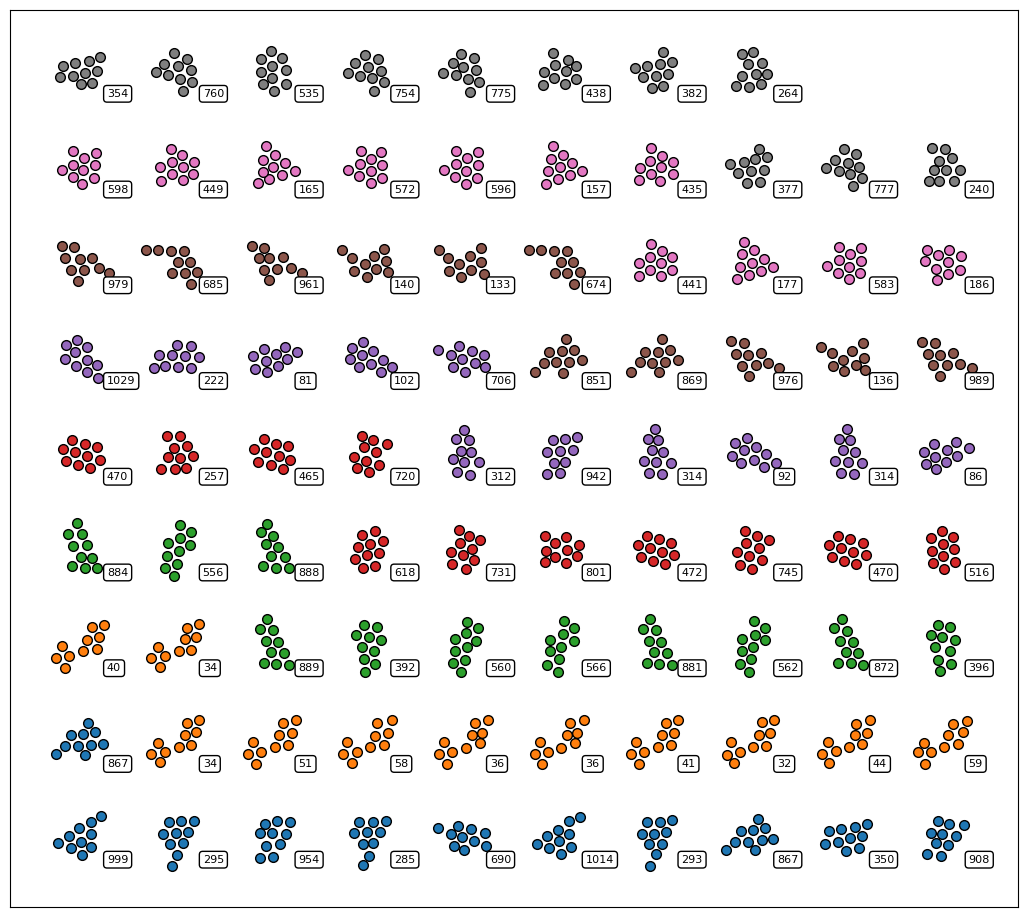

In [132]:
fig, ax = plt.subplots(figsize=(13, 13))
atom_plotters = {label: cluster_anim(markersize=7, default_cols=(f"C{label}", "C1")) for label in atom_cols_labelled}

disp_x = 7.5
disp_y = 7.5

i = 0
j = 0

for label in atom_cols_labelled:
    atom_plotter = atom_plotters[label]
    atom_cols_plot = atom_cols_labelled[label]
    indices = indices_labelled[label]
    for atom_col, index in zip(atom_cols_plot, indices):
        atom_col.reset_plot_axes()
        center_mass = np.mean(atom_col.positions, axis=0)
        disp = np.ones(shape=atom_col.positions.shape)
        disp[:,0]*=i*disp_x
        disp[:,1]*=j*disp_y
        atom_plotter.animate(ax=ax, atom_col=atom_col, displacement=disp-center_mass)
        ax.annotate(text=f"{index}", xy=(i*disp_x+2.0, j*disp_y-2.0), fontsize=8, bbox=dict(boxstyle="round", fc="w"))
        i+=1
        if i == 10:
            i = 0
            j += 1

ax.set_aspect("equal")
s = ax.set_xticks([])
s = ax.set_yticks([])